# Titanic Classification

Research Domain Knowledge: Titanic Kapal Super Britania Raya yang tenggelam karena menabrak sebuah gunung es di Samudra Atlantik Utara pada 15 April 1912 dan mengakibatkan kematian 1.514 penumpang. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
df = pd.read_csv('titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Understanding Every Feature in Dataset:

1. **PassengerId**: ID unik untuk setiap penumpang.
2. **Survived**: Status kelangsungan hidup (1 = selamat, 0 = tidak selamat).
3. **Pclass**: Kelas tiket penumpang (1 = kelas satu, 2 = kelas dua, 3 = kelas tiga).
4. **Name**: Nama lengkap penumpang.
5. **Sex**: Jenis kelamin penumpang (male = pria, female = wanita).
6. **Age**: Usia penumpang (dalam tahun).
7. **SibSp**: Jumlah saudara kandung dan pasangan yang bepergian bersama.
8. **Parch**: Jumlah orang tua dan anak yang bepergian bersama.
9. **Ticket**: Nomor tiket penumpang.
10. **Fare**: Tarif tiket.
11. **Cabin**: Nomor kabin penumpang.
12. **Embarked**: Pelabuhan tempat penumpang naik kapal:
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

## Exploratory Data Analysis

In [3]:
df.drop(columns='PassengerId', inplace=True)

In [4]:
# Informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [5]:
# Cek nilai kosong
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

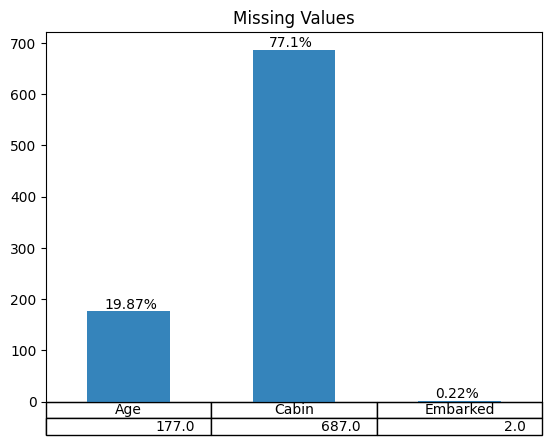

In [6]:
# Persentase Variabel dengan Missing Values
rows_length = df.shape[0]
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind='bar', alpha=0.9, title='Missing Values', table=True)
ax.xaxis.set_visible(False)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

### Handling Missing Values


Jika nilai kosong lebih dari 30%, maka kita bisa menghilangkan kolom tersebut. Jika tidak bisa kita gunakan imputasi statistik

In [7]:
df = df.drop(columns='Cabin', axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [8]:
# Mengganti nilai kosong variabel 'Age' dengan rata-rata
df['Age'].fillna(df['Age'].mean(), inplace=True)
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

In [9]:
# Menemukan indeks nilai terbanyak dari variabel 'Embarked'
print(df['Embarked'].mode())

0    S
Name: Embarked, dtype: object


In [10]:
# 0 adalah indeksnya
print(df['Embarked'].mode()[0])

S


In [11]:
# Mengganti nilai kosong variabel 'Embarked' dengan modus
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [12]:
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [13]:
# Nilai statistik data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
# Menghitung nilai orang yang selamat and tidak selamat
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

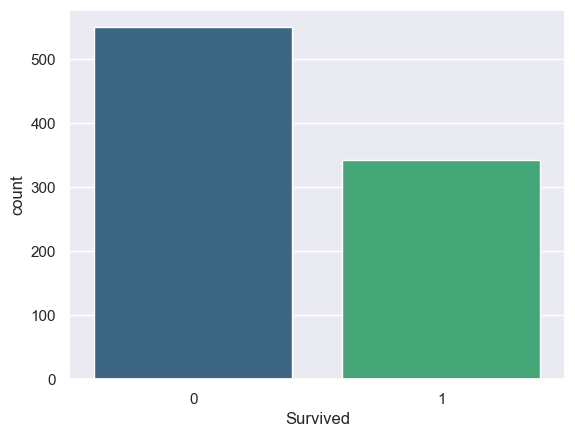

In [15]:
# visualisasi survived
sns.set()
sns.countplot(x='Survived', data=df, palette='viridis')

In [16]:
# Menghitung jenis kelamin penumpang
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

<Axes: xlabel='Sex', ylabel='count'>

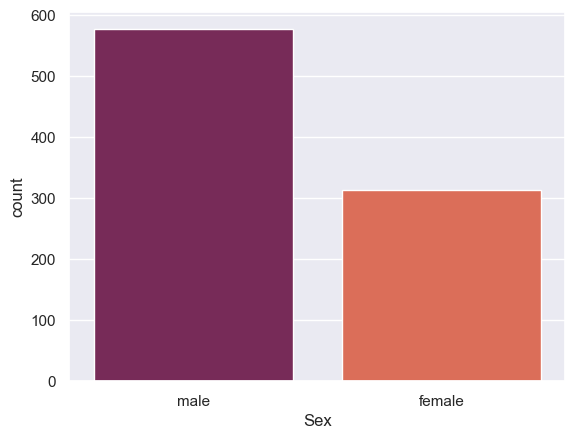

In [17]:
# visualisasi gender
sns.set()
sns.countplot(x='Sex', data=df, palette='rocket')

<Axes: xlabel='Sex', ylabel='count'>

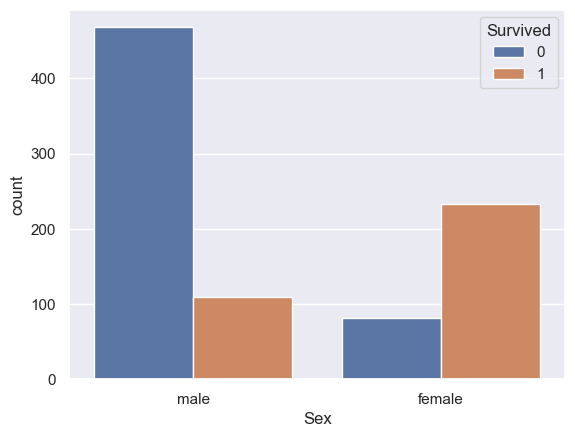

In [18]:
# Orang yang selamat berdasarkan jenis kelamin
sns.countplot(x="Sex", hue="Survived", data=df)

<Axes: xlabel='Pclass', ylabel='count'>

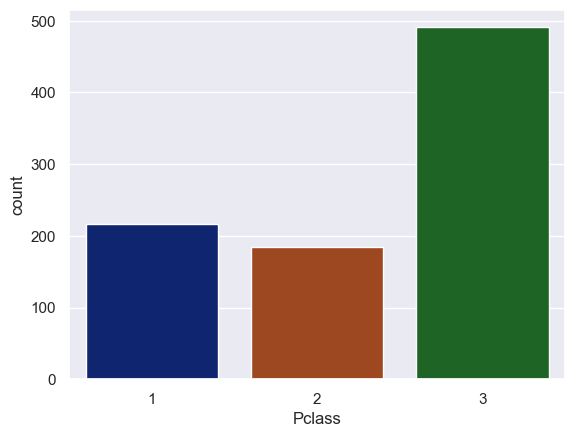

In [19]:
# Creating a Count plot for Pclass Column 
sns.countplot(x="Pclass", data=df, palette='dark')

<Axes: xlabel='Pclass', ylabel='count'>

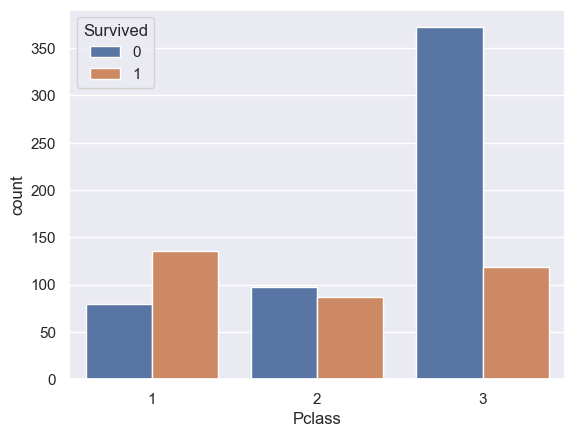

In [20]:
# Menghitung orang yang selamat berdasarkan kelas penumpang
sns.countplot(x="Pclass", hue="Survived", data=df)

### Encoding the Categorical Columns

In [21]:
df["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [22]:
df["Embarked"].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [23]:
# Ubah Nilai Kategorik menjadi Numerik
df.replace({'Sex':{'male':0, 'female':1}, 
                      'Embarked':{'S':0, 'C':1, 'Q':2}}, inplace=True)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0


### Feature Selection

In [24]:
X = df.drop(columns=["Name", "Ticket", "Survived"], axis=1)
Y = df['Survived']

IndexError: index 6 is out of bounds for axis 0 with size 6

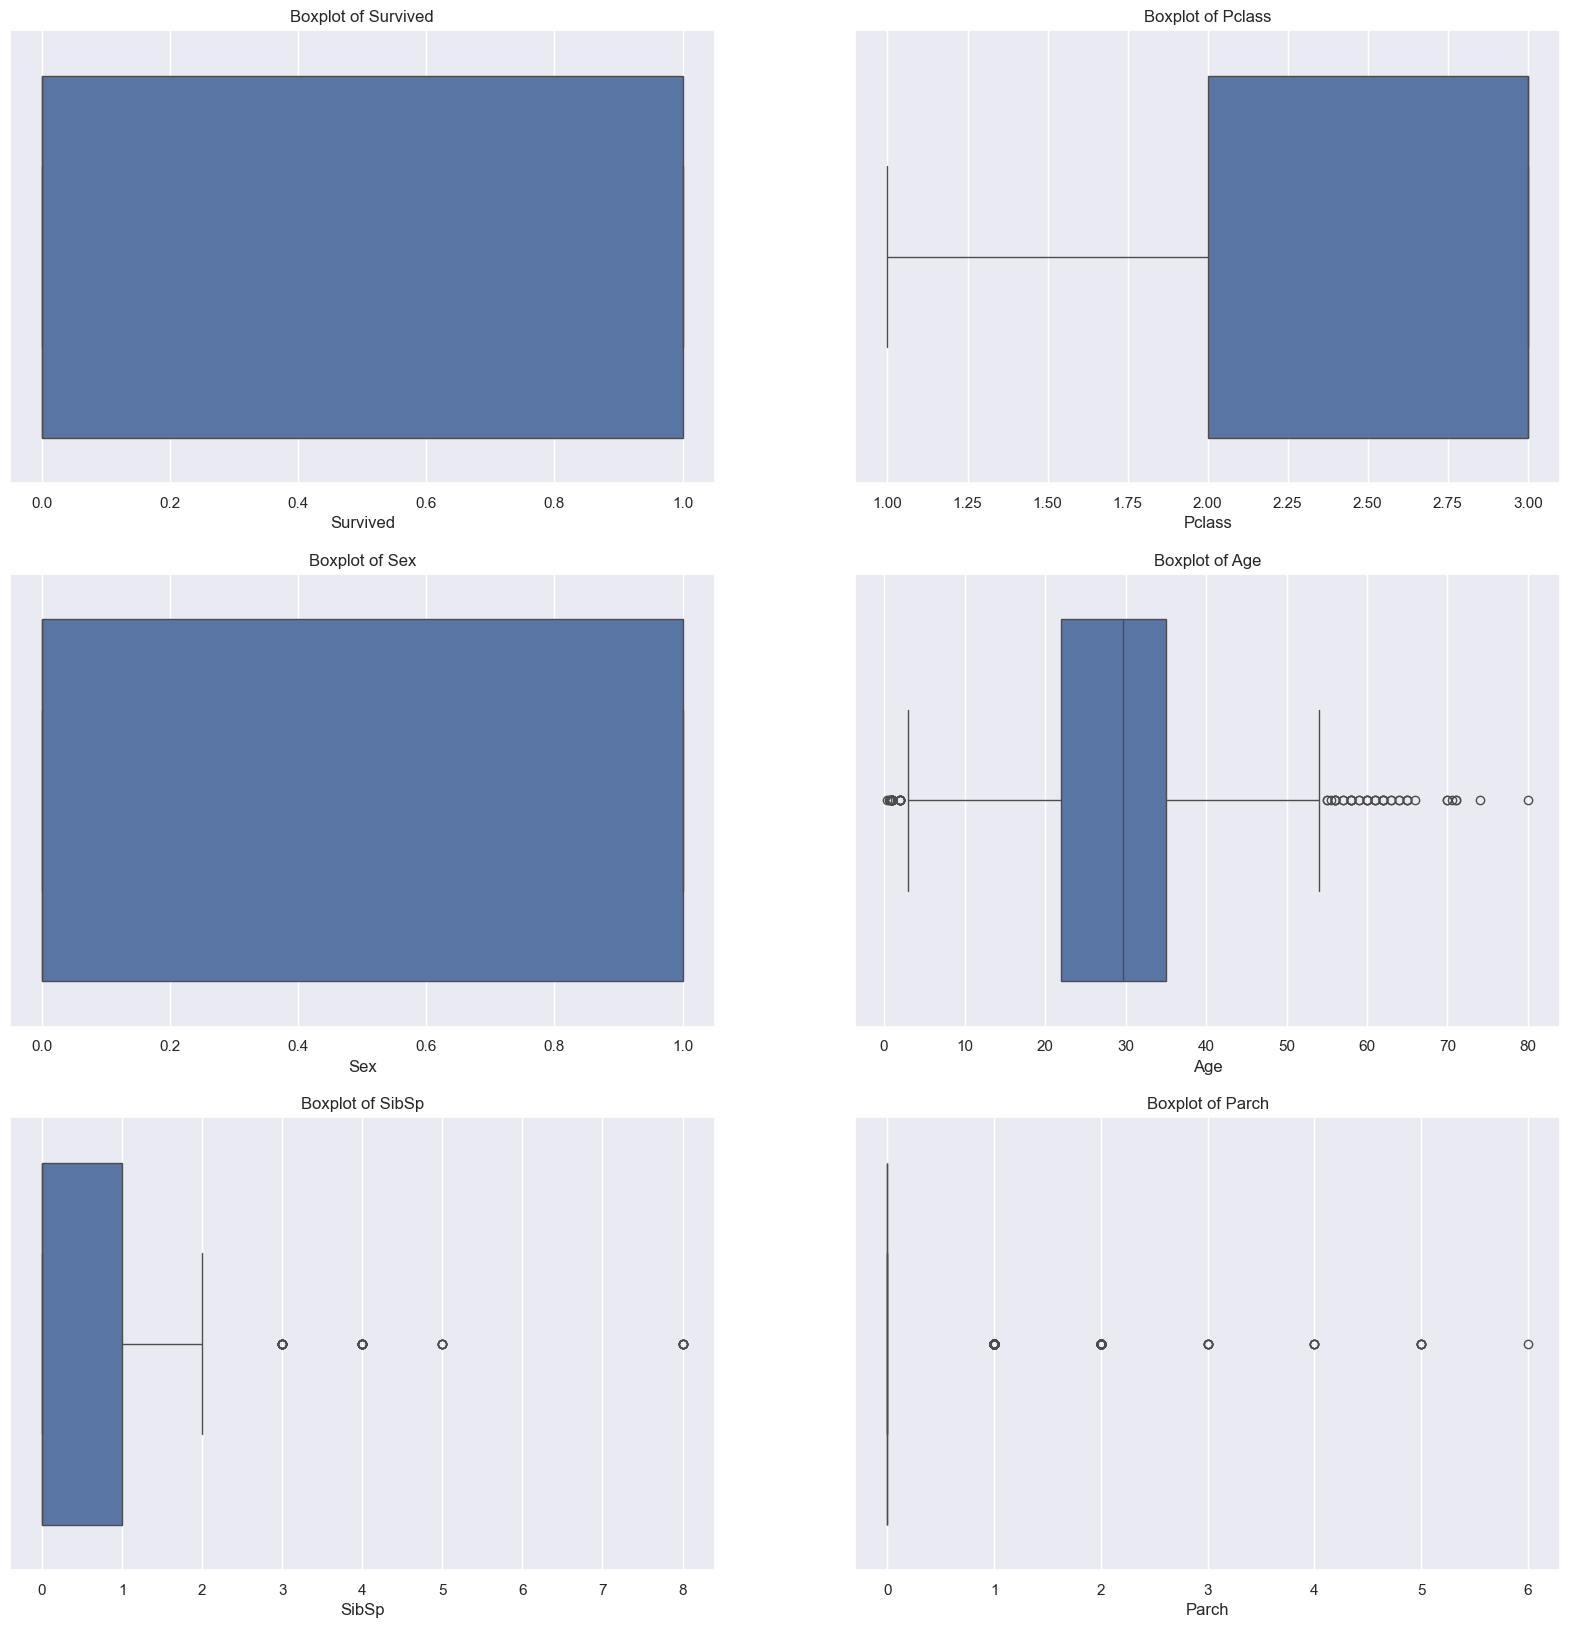

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()
idx = 0

for i in df.select_dtypes(exclude='object'):
    sns.boxplot(x=df[i], ax=axes[idx])
    axes[idx].set_title(f"Boxplot of {i}")
    idx += 1

plt.tight_layout()
plt.show()

In [26]:
from sklearn.preprocessing import RobustScaler

numeric_columns = ['Age', 
               'Fare', 
               'Parch', 
               'SibSp',]

scaler = RobustScaler()
numeric_scaled_array = scaler.fit_transform(df[numeric_columns])
numeric_scaled_df = pd.DataFrame(numeric_scaled_array, columns=numeric_columns)

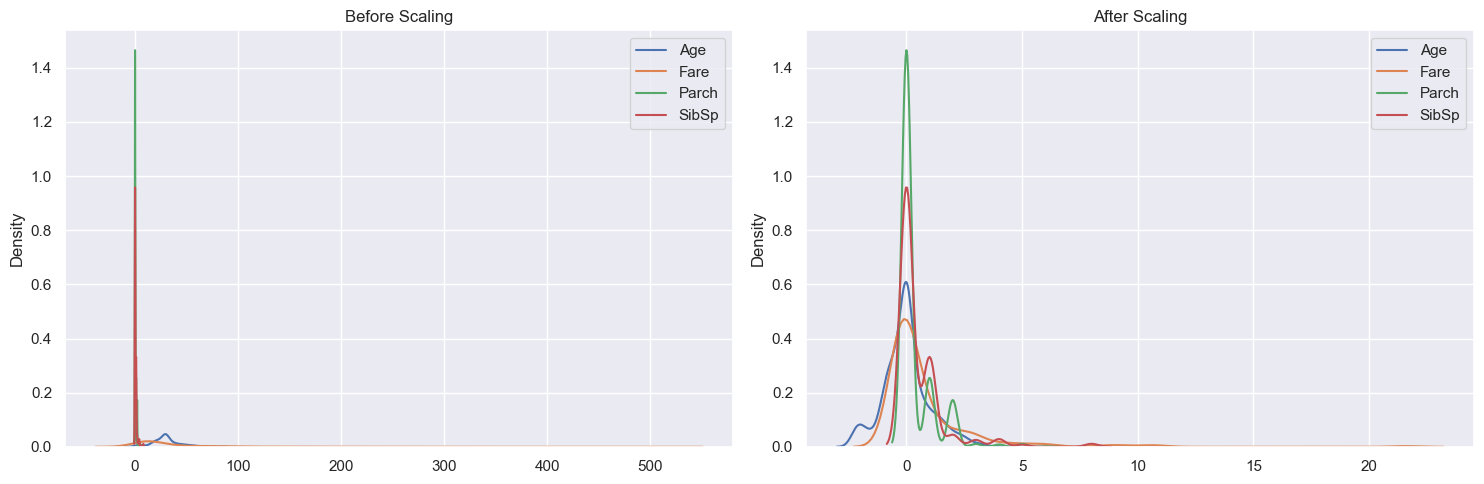

In [27]:
plt.figure(figsize=(15, 5))

# Plot Before Scaling
plt.subplot(121)
for column in numeric_columns:
    sns.distplot(df[column], hist=False, label=column)
plt.title('Before Scaling')
plt.xlabel('')
plt.legend()

# Plot After Scaling
plt.subplot(122)
for column in numeric_columns:
    sns.distplot(numeric_scaled_df[column], hist=False, label=column)
plt.title('After Scaling')
plt.xlabel('')
plt.legend()

plt.tight_layout()
plt.show()

### Handling Outliers with Winsorizing

In [28]:
def winsorize(data, columns_to_winsorize):
 for col in columns_to_winsorize:
   if col not in data.columns or not pd.api.types.is_numeric_dtype(data[col]):
     continue
   lower_bound = data[col].quantile(0.01, interpolation= 'nearest')
   upper_bound = data[col].quantile(0.99, interpolation= 'nearest')

   data.loc[data[col] < lower_bound, col] = lower_bound
   data.loc[data[col] > upper_bound, col] = lower_bound

columns_to_winsorize = df[['Age', 
               'SibSp', 
               'Parch', 
               'Fare',]]
winsorize(df, columns_to_winsorize)

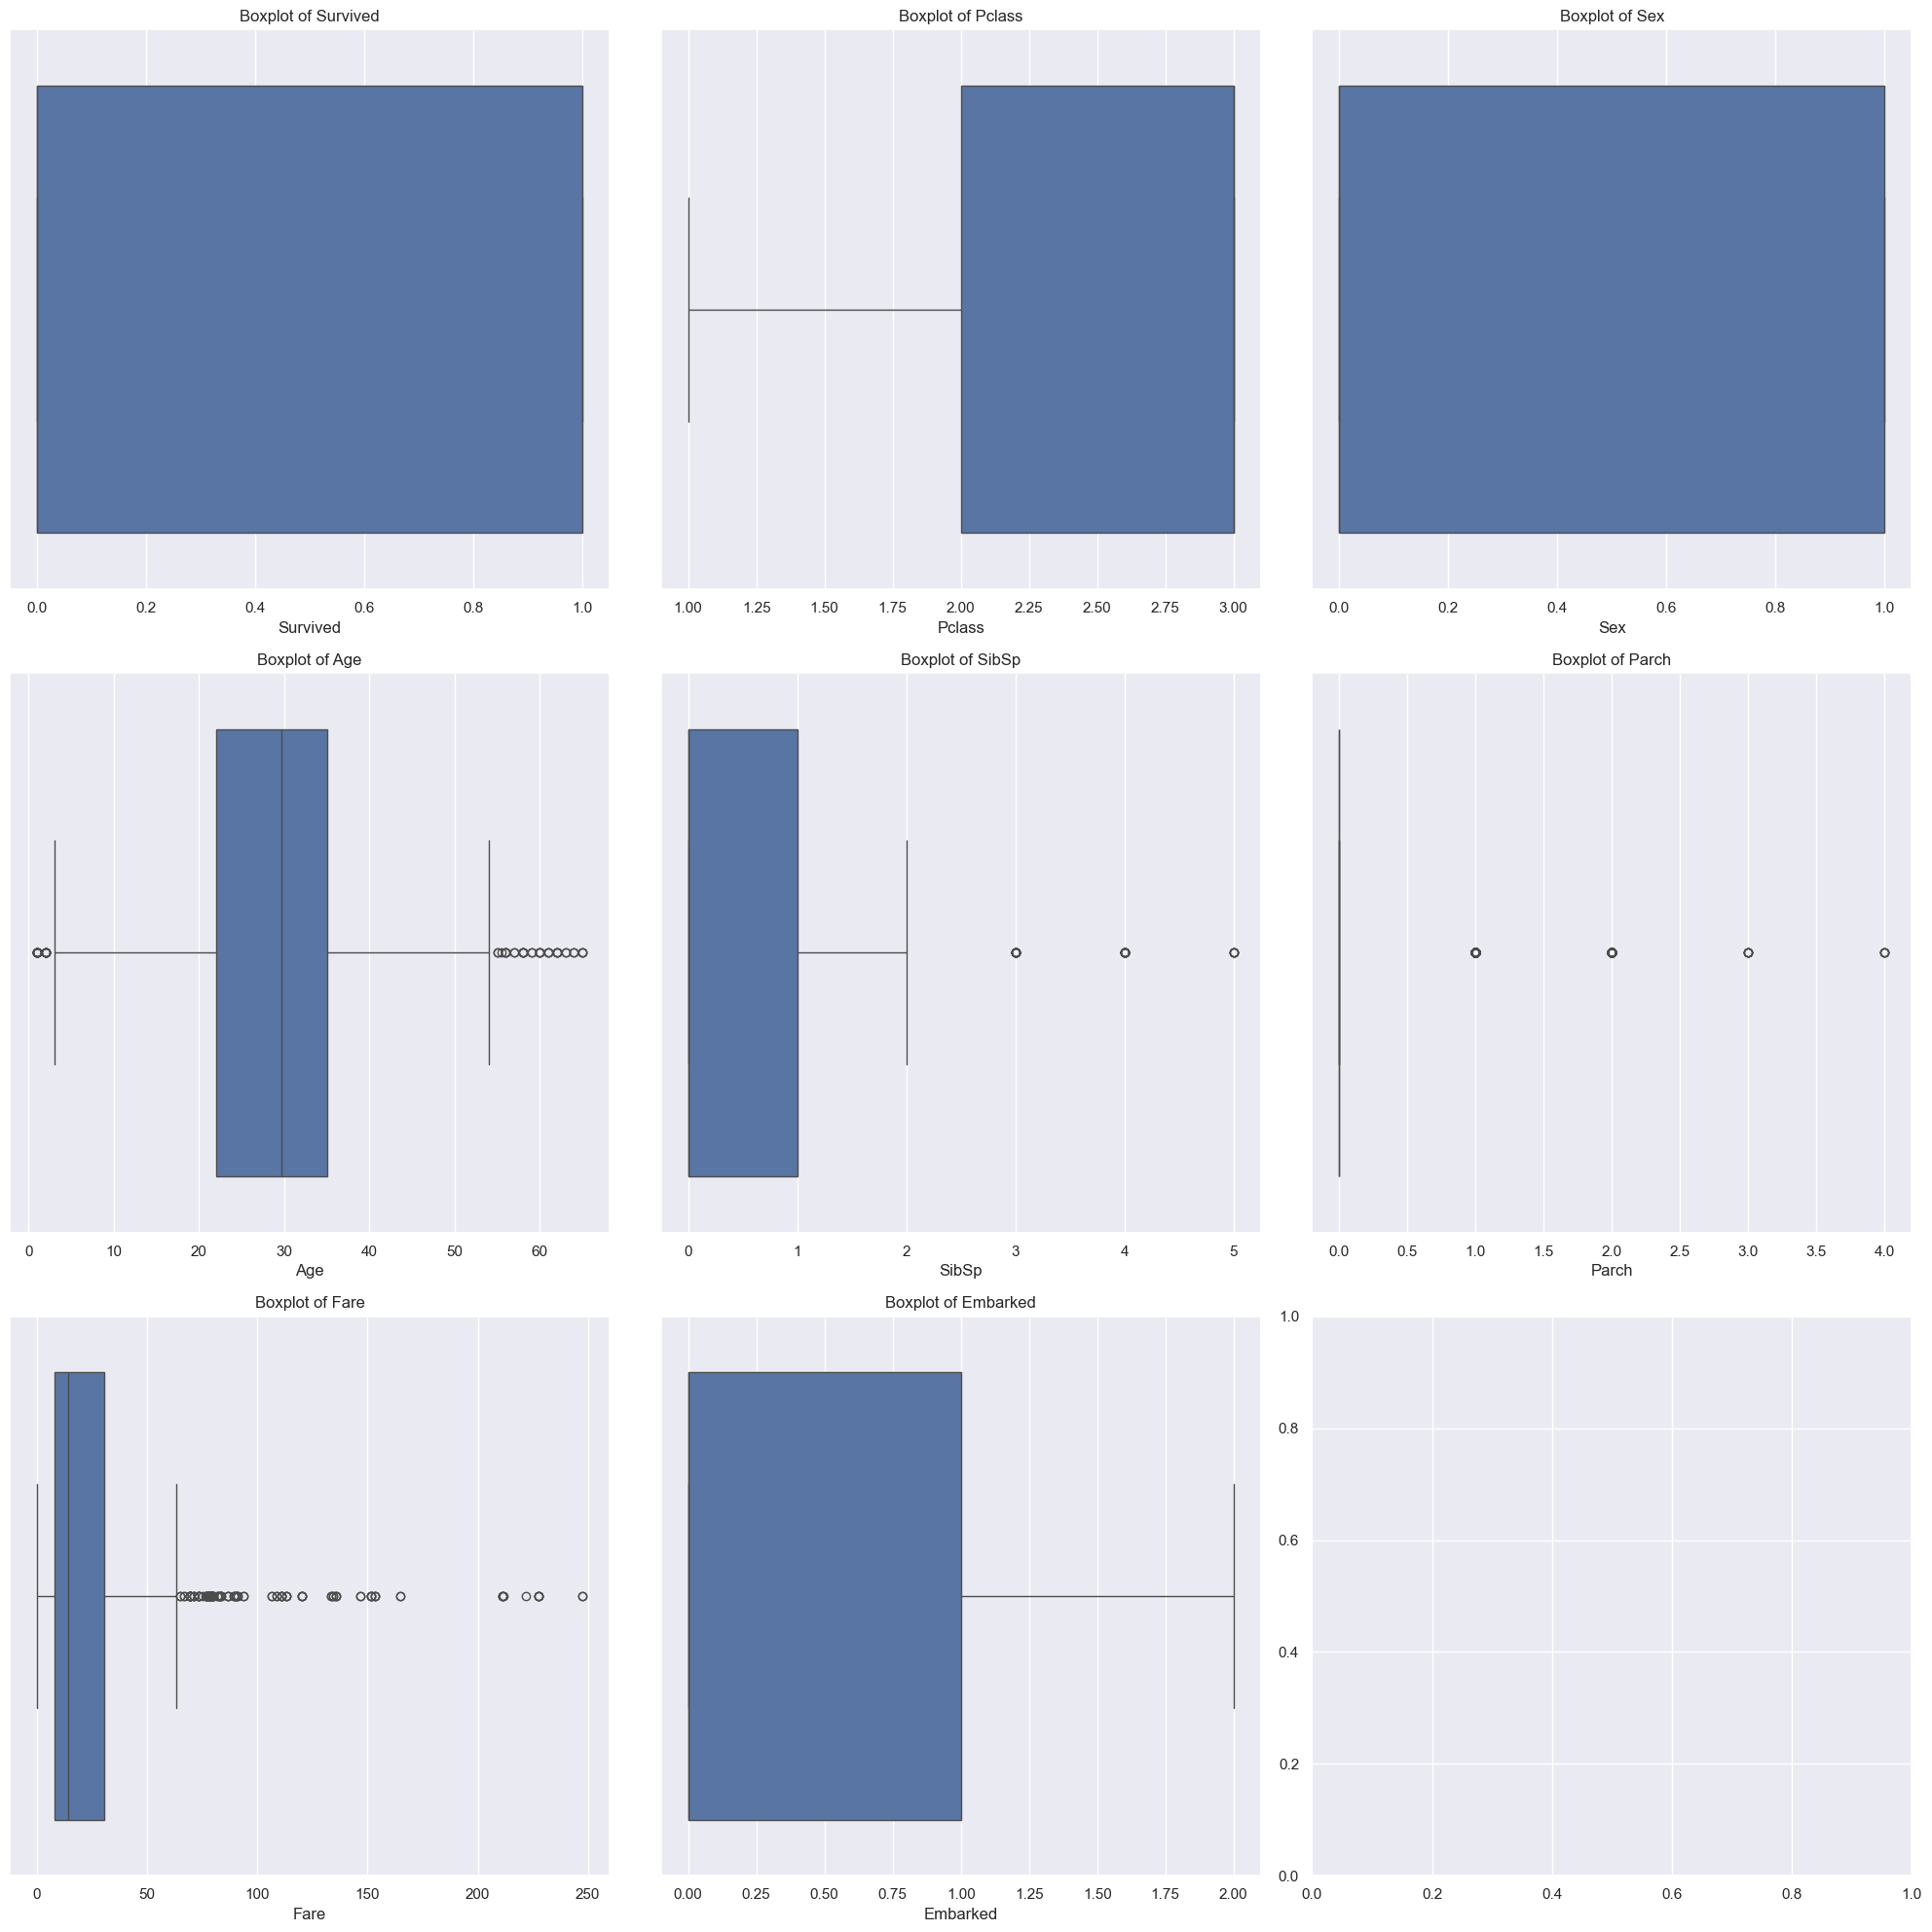

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
idx = 0

for i in df.select_dtypes(exclude='object'):
    sns.boxplot(x=df[i], ax=axes[idx])
    axes[idx].set_title(f"Boxplot of {i}")
    idx += 1

plt.tight_layout()
plt.show()

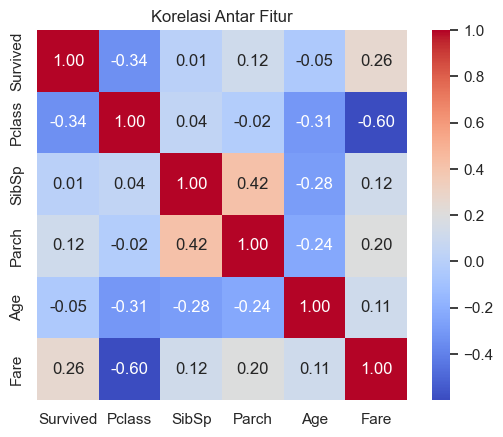

In [30]:
sns.heatmap(df[['Survived','Pclass', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),square=True, annot = True, fmt = '.2f', cmap = 'coolwarm').set_title('Korelasi Antar Fitur');

In [35]:
# Evaluasi Model
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

metrics_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# 10-old cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

fitted_models = {}

for name, model in models.items():
    scores = cross_validate(model, X, Y, cv=kf, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision_weighted'].mean()
    recall = scores['test_recall_weighted'].mean()
    f1 = scores['test_f1_weighted'].mean()

    model.fit(X, Y)
    y_pred = model.predict(X)
    print(f'Classification Report for {name}:')
    print(classification_report(Y, y_pred))
    print('-' * 60)

    metrics_dict['Model'].append(name)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1-Score'].append(f1)

    fitted_models[name] = model

metrics_df = pd.DataFrame(metrics_dict)
print("\nMetrics Summary:")
print(metrics_df.round(4).to_string(index=False))

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       549
           1       0.78      0.68      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891

------------------------------------------------------------
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       549
           1       0.99      0.96      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891

------------------------------------------------------------
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       549
    

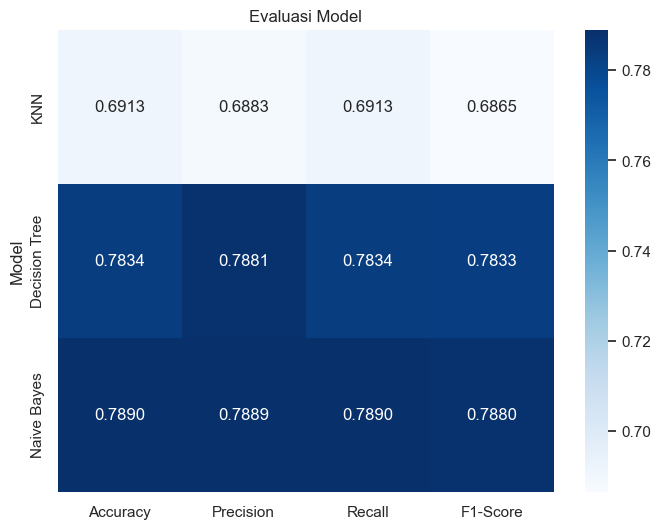

In [36]:
# Visualisasi dengan heatmap
plt.figure(figsize=(8, 6))
metrics_for_heatmap = metrics_df.set_index('Model')
sns.heatmap(metrics_for_heatmap, annot=True, cmap='Blues', fmt='.4f')
plt.title('Evaluasi Model')
plt.show()